# Representaciones Computacionales: Estructuras de Datos Geográficos

**Basado en:** [Geographic Thinking for Data Scientists](https://geographicdata.science/book/notebooks/01_geo_thinking.html)  
**Autores originales:** Rey, Arribas-Bel & Wolf (2020)

---

## ¿Por qué necesitamos estructuras de datos especiales para geografía?

Los datos geográficos tienen una propiedad especial: **todo ocurre en algún lugar**. Pero la ubicación no es solo una coordenada — nos permite entender las *relaciones* entre observaciones. Como señaló el geógrafo Waldo Tobler:

> *"Las cosas cercanas están más relacionadas entre sí que las cosas distantes."* — Primera Ley de la Geografía

Para representar estos datos en una computadora, necesitamos **estructuras de datos** que conecten los modelos conceptuales con la tecnología.

### Las tres estructuras fundamentales:

| Modelo conceptual | Estructura computacional | Librería Python |
|---|---|---|
| **Objetos** (entidades discretas) | Tabla geográfica | `geopandas` |
| **Campos** (superficies continuas) | Grillas / Arrays | `xarray`, `numpy` |
| **Redes** (conexiones entre objetos) | Grafo espacial | `networkx`, `pysal` |

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, Polygon

print("Librerías cargadas correctamente ✓")

Librerías cargadas correctamente ✓


---
## 1. Tablas Geográficas (`GeoDataFrame`)

Las **tablas geográficas** almacenan información sobre *objetos discretos*. Son como una tabla de pandas normal, pero con **una columna especial de geometría** que representa la forma y posición del objeto en el espacio.

La geografía se convierte en "un atributo más", lo que permite combinar información espacial y no espacial de forma natural.

**Casos de uso:** ciudades, países, edificios, paradas de metro, delimitaciones administrativas.

In [2]:
# --- Tabla convencional de pandas ---
df = pd.DataFrame({
    'ciudad'    : ['Santiago', 'Valparaíso', 'Concepción', 'La Serena', 'Antofagasta'],
    'poblacion' : [6_800_000, 1_000_000, 1_000_000, 430_000, 390_000],
    'lon'       : [-70.65, -71.61, -73.05, -71.25, -70.40],
    'lat'       : [-33.45, -33.05, -36.82, -29.91, -23.65]
})

print("DataFrame convencional:")
df

DataFrame convencional:


,ciudad,poblacion,lon,lat
0,Santiago,6800000,-70.65,-33.45
1,Valparaíso,1000000,-71.61,-33.05
2,Concepción,1000000,-73.05,-36.82
3,La Serena,430000,-71.25,-29.91
4,Antofagasta,390000,-70.40,-23.65


In [3]:
# --- Convertir a GeoDataFrame añadiendo geometría ---
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs='EPSG:4326'   # WGS84: el sistema de referencia GPS estándar
)

print("GeoDataFrame (la geografía es solo una columna más):")
print(gdf)
print(f"\nTipo de la columna geometry: {type(gdf.geometry[0])}")

GeoDataFrame (la geografía es solo una columna más):
        ciudad  poblacion    lon    lat                     geometry
0     Santiago    6800000 -70.65 -33.45  POINT (-70.65000 -33.45000)
1   Valparaíso    1000000 -71.61 -33.05  POINT (-71.61000 -33.05000)
2   Concepción    1000000 -73.05 -36.82  POINT (-73.05000 -36.82000)
3    La Serena     430000 -71.25 -29.91  POINT (-71.25000 -29.91000)
4  Antofagasta     390000 -70.40 -23.65  POINT (-70.40000 -23.65000)

Tipo de la columna geometry: <class 'shapely.geometry.point.Point'>


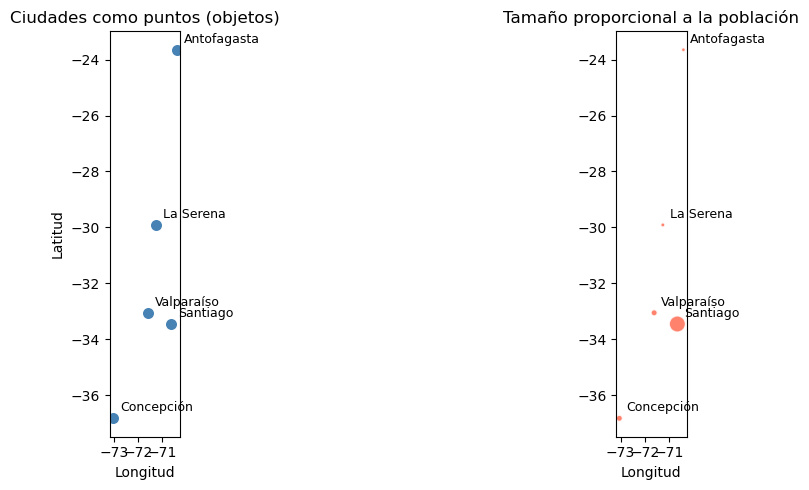

In [4]:
# --- Visualización básica ---
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Mapa de puntos
gdf.plot(ax=axes[0], color='steelblue', markersize=80, edgecolor='white')
for _, row in gdf.iterrows():
    axes[0].annotate(row['ciudad'], xy=(row.geometry.x, row.geometry.y),
                     xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[0].set_title('Ciudades como puntos (objetos)')
axes[0].set_xlabel('Longitud'); axes[0].set_ylabel('Latitud')

# Mapa con tamaño proporcional a la población
gdf.plot(ax=axes[1], color='tomato',
         markersize=gdf['poblacion'] / 50_000,
         edgecolor='white', alpha=0.8)
for _, row in gdf.iterrows():
    axes[1].annotate(row['ciudad'], xy=(row.geometry.x, row.geometry.y),
                     xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1].set_title('Tamaño proporcional a la población')
axes[1].set_xlabel('Longitud')

plt.tight_layout()
plt.show()

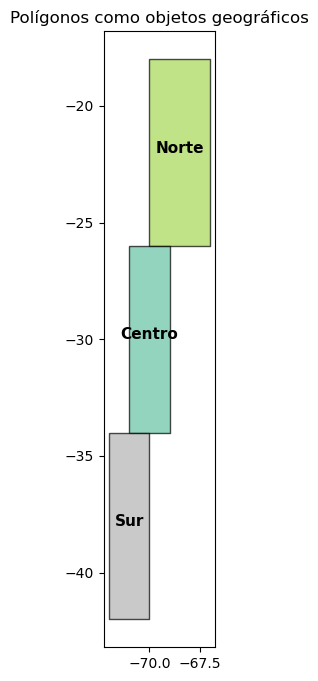


La geografía como atributo más de la tabla:
   region  area_km2                                           geometry
0   Norte    750000  POLYGON ((-70.00000 -18.00000, -67.00000 -18.0...
1  Centro    200000  POLYGON ((-71.00000 -26.00000, -69.00000 -26.0...
2     Sur    490000  POLYGON ((-72.00000 -34.00000, -70.00000 -34.0...


In [5]:
# --- Las geometrías pueden ser más que puntos: polígonos ---
regiones = gpd.GeoDataFrame({
    'region': ['Norte', 'Centro', 'Sur'],
    'area_km2': [750_000, 200_000, 490_000],
    'geometry': [
        Polygon([(-70, -18), (-67, -18), (-67, -26), (-70, -26)]),
        Polygon([(-71, -26), (-69, -26), (-69, -34), (-71, -34)]),
        Polygon([(-72, -34), (-70, -34), (-70, -42), (-72, -42)])
    ]
}, crs='EPSG:4326')

fig, ax = plt.subplots(figsize=(5, 8))
regiones.plot(ax=ax, column='region', cmap='Set2', edgecolor='black', alpha=0.7)
regiones.apply(lambda r: ax.annotate(r['region'],
    xy=r.geometry.centroid.coords[0], ha='center', fontsize=11, fontweight='bold'), axis=1)
ax.set_title('Polígonos como objetos geográficos')
plt.show()

print("\nLa geografía como atributo más de la tabla:")
print(regiones[['region', 'area_km2', 'geometry']])

**Conclusión:** El `GeoDataFrame` de `geopandas` es la implementación Python de la tabla geográfica. La clave es que la geometría es simplemente *una columna más*, lo que permite usar todas las herramientas de pandas junto con operaciones espaciales.

---
## 2. Superficies (Campos Continuos)

Las **superficies** representan fenómenos *continuos* que podrían medirse en cualquier punto del espacio: temperatura, altitud, densidad de población, contaminación atmosférica.

Se implementan como **grillas (arrays 2D)** donde:
- Las **filas** representan latitudes
- Las **columnas** representan longitudes  
- Los **valores de las celdas** almacenan la medición en ese punto

In [ ]:
# --- Simulamos una superficie de temperatura ---
# En la práctica vendría de satélites, sensores, o modelos climáticos

# Definir el área geográfica (Chile central, simplificado)
lons = np.linspace(-74, -68, 60)  # 60 columnas (longitudes)
lats = np.linspace(-20, -45, 80)  # 80 filas (latitudes)

LON, LAT = np.meshgrid(lons, lats)

# Temperatura: más fría al sur y en la montaña (simplificado)
temperatura = 28 + (LAT + 20) * 0.7 + np.random.normal(0, 1.5, LON.shape)

print(f"Forma del array: {temperatura.shape}")
print(f"  → {temperatura.shape[0]} filas (latitudes) × {temperatura.shape[1]} columnas (longitudes)")
print(f"Rango de temperatura: {temperatura.min():.1f}°C a {temperatura.max():.1f}°C")

In [ ]:
# --- Visualización de la superficie ---
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Como imagen raster (estructura real de almacenamiento)
im = axes[0].imshow(temperatura, cmap='RdYlBu_r', origin='upper',
                    extent=[lons[0], lons[-1], lats[-1], lats[0]])
plt.colorbar(im, ax=axes[0], label='Temperatura (°C)')
axes[0].set_title('Superficie como raster / imagen\n(cada píxel = una celda del array)')
axes[0].set_xlabel('Longitud'); axes[0].set_ylabel('Latitud')

# Como mapa de contornos (interpolando entre celdas)
contorno = axes[1].contourf(LON, LAT, temperatura, levels=15, cmap='RdYlBu_r')
plt.colorbar(contorno, ax=axes[1], label='Temperatura (°C)')
axes[1].contour(LON, LAT, temperatura, levels=15, colors='white', linewidths=0.3, alpha=0.5)
axes[1].set_title('Misma superficie como mapa de contornos\n(énfasis en la continuidad)')
axes[1].set_xlabel('Longitud')

plt.suptitle('Campo continuo: Temperatura (superficie simulada)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# --- Cuando hay múltiples fenómenos: el "data cube" ---
# Por ejemplo: temperatura + precipitación + viento → array 3D

precipitacion = 300 - (LAT + 20) * 8 + np.random.normal(0, 30, LON.shape)
viento = 15 + np.random.normal(0, 3, LON.shape)

cubo = np.stack([temperatura, precipitacion, viento], axis=0)
variables = ['Temperatura (°C)', 'Precipitación (mm)', 'Viento (km/h)']

print(f"Forma del cubo de datos: {cubo.shape}")
print(f"  → {cubo.shape[0]} bandas × {cubo.shape[1]} filas × {cubo.shape[2]} columnas")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
cmaps = ['RdYlBu_r', 'Blues', 'Greens']
for i, (ax, var, cmap) in enumerate(zip(axes, variables, cmaps)):
    im = ax.imshow(cubo[i], cmap=cmap, origin='upper',
                   extent=[lons[0], lons[-1], lats[-1], lats[0]])
    plt.colorbar(im, ax=ax, shrink=0.8)
    ax.set_title(f'Banda {i+1}:\n{var}', fontsize=10)
    ax.set_xlabel('Longitud')

plt.suptitle('Data Cube: tres variables geográficas sobre la misma grilla', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

**Conclusión:** Las superficies se almacenan como arrays numéricos. Tanto las filas como las columnas codifican posición geográfica, y los valores codifican el fenómeno medido. Cuando hay múltiples variables o momentos en el tiempo, se forman *data cubes* (arrays 3D o más). La librería estándar en Python para esto es `xarray`.

---
## 3. Redes / Grafos Espaciales

Los **grafos espaciales** capturan *relaciones entre objetos* mediadas por el espacio. Responden a la pregunta: **¿quién está conectado con quién, y cómo?**

Ejemplos: red de metro, sistema de ríos, red de carreteras, conectividad entre vecindarios.

> ⚠️ **Distinción importante:** Una tabla geográfica puede almacenar el *trazado físico* de una calle (su forma y longitud). Un grafo espacial almacena la *estructura de conexiones* entre calles (qué intersección lleva a cuál).

In [ ]:
# --- Construimos una red de metro simplificada ---

# Nodos: estaciones con coordenadas geográficas
estaciones = {
    'Central'    : (-70.664, -33.437),
    'Baquedano'  : (-70.633, -33.437),
    'Santa Ana'  : (-70.677, -33.440),
    'Plaza Italia': (-70.638, -33.434),
    'Tobalaba'   : (-70.608, -33.436),
    'Los Leones' : (-70.615, -33.426),
    'Manuel Montt': (-70.627, -33.420),
    'Parque Bustamante': (-70.630, -33.432),
}

# Aristas: conexiones entre estaciones (con tiempo en minutos)
conexiones = [
    ('Santa Ana', 'Central', {'tiempo': 2, 'linea': 1}),
    ('Central', 'Baquedano', {'tiempo': 3, 'linea': 1}),
    ('Baquedano', 'Plaza Italia', {'tiempo': 2, 'linea': 1}),
    ('Plaza Italia', 'Tobalaba', {'tiempo': 4, 'linea': 1}),
    ('Baquedano', 'Parque Bustamante', {'tiempo': 2, 'linea': 5}),
    ('Parque Bustamante', 'Los Leones', {'tiempo': 3, 'linea': 5}),
    ('Los Leones', 'Manuel Montt', {'tiempo': 2, 'linea': 5}),
    ('Tobalaba', 'Los Leones', {'tiempo': 2, 'linea': 4}),
]

# Construir el grafo
G = nx.Graph()
for nombre, coords in estaciones.items():
    G.add_node(nombre, pos=coords, lon=coords[0], lat=coords[1])
G.add_edges_from(conexiones)

print(f"Red de metro:")
print(f"  Nodos (estaciones): {G.number_of_nodes()}")
print(f"  Aristas (conexiones): {G.number_of_edges()}")
print(f"\nAtributos de un nodo: {G.nodes['Baquedano']}")
print(f"Atributos de una arista: {G.edges['Central', 'Baquedano']}")

In [ ]:
# --- Visualización del grafo espacial ---
pos = nx.get_node_attributes(G, 'pos')

# Separar aristas por línea
linea1 = [(u, v) for u, v, d in G.edges(data=True) if d.get('linea') == 1]
linea4 = [(u, v) for u, v, d in G.edges(data=True) if d.get('linea') == 4]
linea5 = [(u, v) for u, v, d in G.edges(data=True) if d.get('linea') == 5]

fig, ax = plt.subplots(figsize=(10, 6))

nx.draw_networkx_edges(G, pos, edgelist=linea1, edge_color='red',   width=4, ax=ax, label='Línea 1')
nx.draw_networkx_edges(G, pos, edgelist=linea4, edge_color='blue',  width=4, ax=ax, label='Línea 4')
nx.draw_networkx_edges(G, pos, edgelist=linea5, edge_color='green', width=4, ax=ax, label='Línea 5')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='white', edgecolors='black', linewidths=2, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

# Etiquetas de tiempo
edge_labels = {(u, v): f"{d['tiempo']}m" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, ax=ax)

ax.legend(loc='upper left', fontsize=10)
ax.set_title('Red de Metro — Grafo Espacial\n(nodos=estaciones, aristas=conexiones)', fontsize=12, fontweight='bold')
ax.set_xlabel('Longitud'); ax.set_ylabel('Latitud')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# --- Análisis básico de la red ---
print("=== Análisis de la red de metro ===")
print()

# Centralidad de grado: ¿cuántas conexiones tiene cada estación?
centralidad = dict(G.degree())
print("Conexiones por estación (grado):")
for estacion, grado in sorted(centralidad.items(), key=lambda x: -x[1]):
    print(f"  {estacion:<25} {grado} conexiones")

print()

# Ruta más corta entre dos estaciones (por número de paradas)
origen, destino = 'Santa Ana', 'Manuel Montt'
ruta = nx.shortest_path(G, origen, destino)
print(f"Ruta más corta (mín. paradas) de {origen} → {destino}:")
print(f"  {' → '.join(ruta)}  ({len(ruta)-1} paradas)")

# Ruta más rápida (por tiempo)
ruta_rapida = nx.shortest_path(G, origen, destino, weight='tiempo')
tiempo_total = sum(G[ruta_rapida[i]][ruta_rapida[i+1]]['tiempo'] for i in range(len(ruta_rapida)-1))
print(f"\nRuta más rápida (mín. tiempo) de {origen} → {destino}:")
print(f"  {' → '.join(ruta_rapida)}  ({tiempo_total} minutos)")

**Conclusión:** Los grafos espaciales codifican *topología*, es decir, quién está conectado con quién. Esto habilita análisis como rutas más cortas, centralidad, y comunidades. La librería principal en Python es `networkx`; para análisis de pesos espaciales se usa `pysal`.

---
## Resumen: Las tres estructuras y sus herramientas

In [ ]:
# --- Visualización comparativa de las tres estructuras ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Tabla geográfica
gdf.plot(ax=axes[0], color='steelblue', markersize=100, edgecolor='white')
for _, row in gdf.iterrows():
    axes[0].annotate(row['ciudad'], xy=(row.geometry.x, row.geometry.y),
                     xytext=(4, 4), textcoords='offset points', fontsize=8)
axes[0].set_title('1. Tabla Geográfica\n(objetos discretos)', fontweight='bold')
axes[0].set_xlabel('geopandas → GeoDataFrame')

# 2. Superficie
im = axes[1].imshow(temperatura, cmap='RdYlBu_r', origin='upper',
                    extent=[lons[0], lons[-1], lats[-1], lats[0]], aspect='auto')
plt.colorbar(im, ax=axes[1], label='°C', shrink=0.8)
axes[1].set_title('2. Superficie (Campo continuo)\n(fenómeno medible en cualquier punto)', fontweight='bold')
axes[1].set_xlabel('numpy / xarray → ndarray')

# 3. Grafo espacial
nx.draw_networkx_edges(G, pos, ax=axes[2], width=2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, ax=axes[2], node_size=300,
                       node_color='white', edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G, pos, ax=axes[2], font_size=7)
axes[2].set_title('3. Grafo Espacial\n(relaciones y conexiones)', fontweight='bold')
axes[2].set_xlabel('networkx / pysal → Graph')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Representaciones Computacionales de Datos Geográficos',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Reflexión final: ¿La separación está desapareciendo?

Como señalan Rey, Arribas-Bel y Wolf, las fronteras entre estas tres estructuras se están difuminando:

- El **Machine Learning** hace más fácil convertir datos entre representaciones (problema de *change of support*).
- Sistemas como **H3 de Uber** o **S2 de Google** buscan una representación hexagonal universal.
- Datos de población (tradicionalmente en tablas) ahora también se publican como **rasters continuos** (ej: WorldPop).

Pero la pregunta sigue siendo válida: **¿se *puede* usar esta representación para mi problema, o se *debería* usar?**

La respuesta depende tanto del fenómeno como del objetivo analítico.

---
*Notebook preparado para curso de Ciencia de Datos Geográficos.*  
*Referencia: [Geographic Data Science with Python](https://geographicdata.science/book/) — Rey, Arribas-Bel & Wolf (2020)*